In [1]:
import numpy as np
import matplotlib.pyplot as plt  # Just so we can visually confirm we have the same images
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.utils#.data.Dataset
import glob
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

from random import shuffle

from torch.optim.lr_scheduler import StepLR

from random import shuffle
from numpy import percentile

import random
import cv2

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms
import torchvision.transforms.functional as TF
gpu_number = "0"            

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number
import PIL
from PIL import Image
i=plt.imread('/home/Drive/rahul/weizmann_horse_db/figure_ground/horse116.jpg')/255
print(np.unique(i))

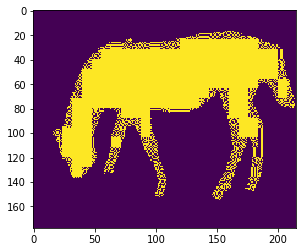

[0 1]


In [4]:
i=np.array(Image.open('/home/Drive/rahul/weizmann_horse_db/figure_ground/horse186.jpg'))/255
plt.imshow(i); plt.show();print(np.unique(i))


In [7]:

def one_hot(a):
    a=torch.tensor(a)
    g1=a[:,:]==0
    g2=a[:,:]==1

    return torch.stack((g1,g2),0)


class NDataset(Dataset):
    """Heart MRI Dataset dataset."""
    
    def __init__(self,mode,transform=False):

        self.im_list=glob.glob('weizmann_horse_db/gray/*')        
        
        
        if mode=='train':
            self.im_list=self.im_list[:-32]
        else:
            self.im_list=self.im_list[-32:]
        self.transform = transform
        
        self.mean=0
        self.std=0
    def __len__(self):
        return len(self.im_list)
    
    def __getitem__(self, idx,h=None,w=None):
        small_flag = 0
        image=Image.open(self.im_list[idx]).resize((244,244))
        name=self.im_list[idx][23:]
        mask=Image.open('weizmann_horse_db/figure_ground/'+name)
        mask=mask.resize((244,244))
        image=np.array(image);mask=np.array(mask)/255
#         print(name)
        image = image - 120.97480
        image = image / (68.9428266)
        image = torch.tensor(image)#.transpose(1,2).transpose(0,1)

        
        groundTruth = mask 
        groundTruth = torch.from_numpy(groundTruth).float()#.unsqueeze(0)



        seg=one_hot(groundTruth) 
        
        sample = {'image': image.unsqueeze(0), 'mask':seg,'mask2': groundTruth,  'small_flag': small_flag,'name':name }
        return sample



In [8]:
ds=NDataset('train')

In [9]:
a=iter(ds)

In [10]:
d=next(a)
np.shape(d['image'])

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([1, 244, 244])

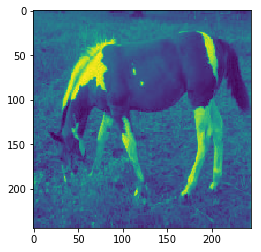

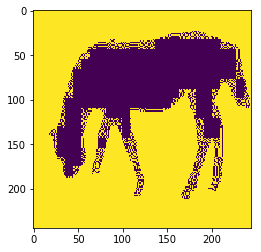

In [11]:
plt.imshow(d['image'][0]);plt.show()
plt.imshow(d['mask'][0]); plt.show()

In [12]:


import torch.nn.functional as F


class double_conv(torch.nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(torch.nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = torch.nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [13]:
n_classes=2
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
#         print(x5.size())
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [14]:


def dice_loss_classes(inpu, target):  # [bs,4,96,96,64]

    ip=inpu[:,0,:,:].contiguous().view(-1)
    tar=target[:,0,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score1=1-2*(intersection/union)
    

    ip=inpu[:,1,:,:].contiguous().view(-1)
    tar=target[:,1,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score2=1-2*(intersection/union)
     
    
    return score1,score2


In [15]:
# Some useful functions for train stats

def loss_to_score(my_dict): # converts dice loss to scores (1-loss)
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            my_dict[e][i]=1-my_dict[e][i]
    return(my_dict)


def val_stats(my_dict,threshold=0.8,compare=None):
#     my_dict=loss_to_score(my_dict)
    l=[]
    eps=1
    
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            l.append(my_dict[e][i])
#     print(l)       
    print('Global Mean: ', sum(l)/len(l))
    print('Global Std: ', np.std(np.array(l)))
    g=[]
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]>threshold:
                g.append(my_dict[e][i])
    c=0
    for i in range(eps):
        
        print('Epoch: ',i-1, 'with ',c,'below')
        c=0
        for e in my_dict.keys():
            if my_dict[e][i]<=threshold:
                c+=1
            
    clip={}
    counter=0
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]<=threshold:
                counter+=1
                
                if e not in clip.keys():clip[e]=[my_dict[e][i]]
                else:clip[e].append(my_dict[e][i])
            
    try:print('Clipped Mean: ', sum(g)/len(g))
    except: pass
    print('Number clipped: ', counter, 'of total ', len(l))
    
    print('Suspects: ')
    
    suspect_dict={}
    for e in clip.keys():
        suspect_dict[e]=my_dict[e]
        print(e,clip[e])
        
    data=np.array(l)
    quartiles = percentile(data, [25, 50, 75])
    # calculate min/max
    data_min, data_max = data.min(), data.max()
    # print 5-number summary
    print('--')
    print('--')
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)
    
#     plt.plot(sorted(l))
#     plt.show()
    plt.hist(l)#,bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]*0.05)
    plt.title("histogram") 
    plt.show()
    
    if compare:
        print('Deltas')
        for e in my_dict.keys():
            print(e,' : ', sum(compare[e])/len(compare[e])-sum(my_dict[e]/len(my_dict[e])))
    return(suspect_dict)
    
def tta(my_dict):
    tta=[]
    for e in my_dict.keys():
        print(e,': ', sum(my_dict[e])/len(my_dict[e]), min(my_dict[e]), max(my_dict[e]))
        tta.append(sum(my_dict[e])/len(my_dict[e]))
    print('--')
    
    print('TTA Avg: ',sum(tta)/len(tta))    
    
def make_a(my_dict): # makes a dict on only class 0 dice scores from dict with [class 0, class 1]
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][0]][0] # takes first elemtn !
    return(dicta)
def make_b(my_dict):# makes a dict on only class 1 dice scores 
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][1]][0]
    return(dicta)       
        
def diff_checker(big1,big2):
    # Takes in hotlist and biglist of two trains
    # gets all culprits in both sets and returns a comparsion of those
    # biglist needed as some items only in one hotlist

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][1][0]
            s2=big2[e][1][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)

def diff_checker2(big1,big2):
    # Takes in   biglist of single dice vals

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][0]
            s2=big2[e][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n   

# Baseline Train

In [16]:

model=UNet(1,2).cuda()
batch_size=3;batch_size_val=3


# for param in model.down4hard.parameters(): # freeze
#     param.requires_grad = False

    
    
dataset = NDataset('train')
dataset_val=NDataset('val')    #val
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
loaders={'train':data_loader,'val': val_loader}

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()  
soft_max=torch.nn.Softmax(dim=1)
init_lr=0.001


opt = torch.optim.Adam(model.parameters(), lr=init_lr)

In [18]:
dataset_val=NDataset('val')    #val


In [22]:
def trainer(model,epochs,loaders=None,opt=opt):
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    
    if loaders==None:
        data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
        val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
        loaders={'train':data_loader,'val': val_loader}
    
    for epoch in range(epochs):
        for e in loaders:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False


            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()
                    pred_mask = model(input)
#                     print(np.unique(pred_mask.cpu().detach().numpy()),np.unique(ce_tar.cpu().detach().numpy()))
                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)

                    a,b=dice_loss_classes(soft_mask, dice_mask)

                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)

                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)

                        print('Epoch: ', epoch+1, ' Batch: ',idx+1,' Dice0: ', round(dice0,3),' Dice1: ', round(dice1,3), ' CE: ',round(cross_moving_avg,3),' Loss :' ,round(loss_moving_avg,3))
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
def valider(model,epochs=3,loaders_eval=None,opt=opt):
    if loaders_eval==None:
        data_eval = DataLoader(dataset, 1, shuffle=True, num_workers=2)
        val_eval=DataLoader(dataset_val,1,shuffle=True, num_workers=2) 
        loaders_eval={'val': val_eval,'train':data_eval}
    epochs=epochs
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    for epoch in range(epochs):
        for e in loaders_eval:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False


            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders_eval[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()#.to(device)
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()

                    pred_mask = model(input)

                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)
                    
                    a,b=dice_loss_classes(soft_mask, dice_mask)
                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)

                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)

                        print('Epoch: ', epoch+1, ' Batch: ',idx+1,' Dice0: ', round(dice0,3),' Dice1: ', round(dice1,3), ' CE: ',round(cross_moving_avg,3),' Loss :' ,round(loss_moving_avg,3))
    #                     loss.backward()
    #                     opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))


In [23]:
my_dict={}
my_dict_val={}

L=np.array([]);Lc=np.array([]);Ld=np.array([]);Lv=np.array([]);Lvd=np.array([]);Lvc=np.array([]);L_r=np.array([]);Ldc=np.array([]);Lvdc=np.array([])


In [30]:


trainer(model,50)

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.124, ' Loss :', 0.224)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.044, ' Dice1: ', 0.155, ' CE: ', 0.12

('Epoch: ', 1, ' Batch: ', 82, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 83, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 84, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 85, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 86, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 87, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.223)
('Epoch: ', 1, ' Batch: ', 88, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.222)
('Epoch: ', 1, ' Batch: ', 89, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.222)
('Epoch: ', 1, ' Batch: ', 90, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.124, ' Loss :', 0.222)
('Epoch: ', 1, ' Batch: ', 91, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.045, ' Dice1: ', 0.133, ' CE: ', 0.14, ' Loss :', 0.222316)
('Val Dice0', 0.051, ' Dice1: ', 0.211, ' CE: ', 0.219, ' Loss :', 0.222316)
('Val Dice0', 0.028, ' Dice1: ', 0.112, ' CE: ', 0.081, ' Loss :', 0.222316)
('Val Dice0', 0.031, ' Dice1: ', 0.152, ' CE: ', 0.129, ' Loss :', 0.222316)
('Val Dice0', 0.021, ' Dice1: ', 0.151, ' CE: ', 0.066, ' Loss :', 0.222316)
('Val Dice0', 0.042, ' Dice1: ', 0.13, ' CE: ', 0.141, ' Loss :', 0.222316)
('Val Dice0', 0.032, ' Dice1: ', 0.142, ' CE: ', 0.094, ' Loss :', 0.222316)
('Val Dice0', 0.042, ' Dice1: ', 0.142, ' CE: ', 0.157, ' Loss :', 0.222316)
('Val Dice0', 0.037, ' Dice1: ', 0.147, ' CE: ', 0.124, ' Loss :', 0.222316)
('Val Dice0', 0.034, ' Dice1: ', 0.13, ' CE: ', 0.099, ' Loss :', 0.222316)
('Val Dice0', 0.033, ' Dice1: ', 0.121, ' CE: ', 0.089, ' Loss :', 0.222316)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 2, ' Batch: ', 1, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 2, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 3, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 4, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 5, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 6, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 7, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 8, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 9, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.123, ' Loss :', 0.222)
('Epoch: ', 2, ' Batch: ', 10, ' Dice0: ', 0.043, ' Dice1: ', 0.154, ' CE: ', 0.12

('Epoch: ', 2, ' Batch: ', 82, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 83, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 84, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 85, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 86, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 87, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 88, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 89, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 90, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 2, ' Batch: ', 91, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.04, ' Dice1: ', 0.137, ' CE: ', 0.17, ' Loss :', 0.22089)
('Val Dice0', 0.048, ' Dice1: ', 0.205, ' CE: ', 0.226, ' Loss :', 0.22089)
('Val Dice0', 0.036, ' Dice1: ', 0.155, ' CE: ', 0.149, ' Loss :', 0.22089)
('Val Dice0', 0.046, ' Dice1: ', 0.134, ' CE: ', 0.146, ' Loss :', 0.22089)
('Val Dice0', 0.032, ' Dice1: ', 0.125, ' CE: ', 0.103, ' Loss :', 0.22089)
('Val Dice0', 0.03, ' Dice1: ', 0.16, ' CE: ', 0.115, ' Loss :', 0.22089)
('Val Dice0', 0.026, ' Dice1: ', 0.113, ' CE: ', 0.08, ' Loss :', 0.22089)
('Val Dice0', 0.035, ' Dice1: ', 0.128, ' CE: ', 0.114, ' Loss :', 0.22089)
('Val Dice0', 0.023, ' Dice1: ', 0.122, ' CE: ', 0.074, ' Loss :', 0.22089)
('Val Dice0', 0.039, ' Dice1: ', 0.131, ' CE: ', 0.131, ' Loss :', 0.22089)
('Val Dice0', 0.031, ' Dice1: ', 0.106, ' CE: ', 0.096, ' Loss :', 0.22089)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 3, ' Batch: ', 1, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 2, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 3, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 4, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 5, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 6, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 7, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 8, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 9, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.123, ' Loss :', 0.221)
('Epoch: ', 3, ' Batch: ', 10, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.12

('Epoch: ', 3, ' Batch: ', 82, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 83, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 84, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 85, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 86, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 87, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 88, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 89, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 90, ' Dice0: ', 0.043, ' Dice1: ', 0.153, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 3, ' Batch: ', 91, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.12

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.035, ' Dice1: ', 0.119, ' CE: ', 0.107, ' Loss :', 0.21952)
('Val Dice0', 0.03, ' Dice1: ', 0.121, ' CE: ', 0.098, ' Loss :', 0.21952)
('Val Dice0', 0.038, ' Dice1: ', 0.119, ' CE: ', 0.111, ' Loss :', 0.21952)
('Val Dice0', 0.046, ' Dice1: ', 0.157, ' CE: ', 0.172, ' Loss :', 0.21952)
('Val Dice0', 0.027, ' Dice1: ', 0.175, ' CE: ', 0.104, ' Loss :', 0.21952)
('Val Dice0', 0.041, ' Dice1: ', 0.148, ' CE: ', 0.15, ' Loss :', 0.21952)
('Val Dice0', 0.033, ' Dice1: ', 0.123, ' CE: ', 0.12, ' Loss :', 0.21952)
('Val Dice0', 0.025, ' Dice1: ', 0.145, ' CE: ', 0.085, ' Loss :', 0.21952)
('Val Dice0', 0.033, ' Dice1: ', 0.124, ' CE: ', 0.092, ' Loss :', 0.21952)
('Val Dice0', 0.032, ' Dice1: ', 0.131, ' CE: ', 0.098, ' Loss :', 0.21952)
('Val Dice0', 0.07, ' Dice1: ', 0.238, ' CE: ', 0.341, ' Loss :', 0.21952)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 4, ' Batch: ', 1, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.22)
('Epoch: ', 4, ' Batch: ', 2, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 3, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 4, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 5, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 6, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 7, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 8, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 9, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122, ' Loss :', 0.219)
('Epoch: ', 4, ' Batch: ', 10, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.122

('Epoch: ', 4, ' Batch: ', 82, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 83, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 84, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 85, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 86, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 87, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 88, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 89, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 90, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 4, ' Batch: ', 91, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.04, ' Dice1: ', 0.136, ' CE: ', 0.112, ' Loss :', 0.218174)
('Val Dice0', 0.04, ' Dice1: ', 0.132, ' CE: ', 0.122, ' Loss :', 0.218174)
('Val Dice0', 0.037, ' Dice1: ', 0.154, ' CE: ', 0.149, ' Loss :', 0.218174)
('Val Dice0', 0.049, ' Dice1: ', 0.249, ' CE: ', 0.236, ' Loss :', 0.218174)
('Val Dice0', 0.032, ' Dice1: ', 0.132, ' CE: ', 0.123, ' Loss :', 0.218174)
('Val Dice0', 0.036, ' Dice1: ', 0.14, ' CE: ', 0.107, ' Loss :', 0.218174)
('Val Dice0', 0.031, ' Dice1: ', 0.115, ' CE: ', 0.094, ' Loss :', 0.218174)
('Val Dice0', 0.028, ' Dice1: ', 0.118, ' CE: ', 0.081, ' Loss :', 0.218174)
('Val Dice0', 0.041, ' Dice1: ', 0.142, ' CE: ', 0.139, ' Loss :', 0.218174)
('Val Dice0', 0.031, ' Dice1: ', 0.116, ' CE: ', 0.094, ' Loss :', 0.218174)
('Val Dice0', 0.035, ' Dice1: ', 0.148, ' CE: ', 0.112, ' Loss :', 0.218174)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 5, ' Batch: ', 1, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 2, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 3, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 4, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 5, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 6, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 7, ' Dice0: ', 0.043, ' Dice1: ', 0.152, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 8, ' Dice0: ', 0.043, ' Dice1: ', 0.151, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 9, ' Dice0: ', 0.043, ' Dice1: ', 0.151, ' CE: ', 0.121, ' Loss :', 0.218)
('Epoch: ', 5, ' Batch: ', 10, ' Dice0: ', 0.043, ' Dice1: ', 0.151, ' CE: ', 0.12

('Epoch: ', 5, ' Batch: ', 82, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 83, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 84, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 85, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 86, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 87, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 88, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 89, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 90, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 5, ' Batch: ', 91, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.035, ' Dice1: ', 0.136, ' CE: ', 0.13, ' Loss :', 0.216875)
('Val Dice0', 0.03, ' Dice1: ', 0.11, ' CE: ', 0.089, ' Loss :', 0.216875)
('Val Dice0', 0.024, ' Dice1: ', 0.132, ' CE: ', 0.077, ' Loss :', 0.216875)
('Val Dice0', 0.039, ' Dice1: ', 0.145, ' CE: ', 0.127, ' Loss :', 0.216875)
('Val Dice0', 0.02, ' Dice1: ', 0.164, ' CE: ', 0.063, ' Loss :', 0.216875)
('Val Dice0', 0.039, ' Dice1: ', 0.114, ' CE: ', 0.112, ' Loss :', 0.216875)
('Val Dice0', 0.036, ' Dice1: ', 0.114, ' CE: ', 0.103, ' Loss :', 0.216875)
('Val Dice0', 0.037, ' Dice1: ', 0.139, ' CE: ', 0.125, ' Loss :', 0.216875)
('Val Dice0', 0.04, ' Dice1: ', 0.161, ' CE: ', 0.162, ' Loss :', 0.216875)
('Val Dice0', 0.057, ' Dice1: ', 0.212, ' CE: ', 0.262, ' Loss :', 0.216875)
('Val Dice0', 0.041, ' Dice1: ', 0.136, ' CE: ', 0.174, ' Loss :', 0.216875)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 6, ' Batch: ', 1, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 2, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 3, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 4, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 5, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 6, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 7, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 8, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 9, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss :', 0.217)
('Epoch: ', 6, ' Batch: ', 10, ' Dice0: ', 0.042, ' Dice1: ', 0.151, ' CE: ', 0.12, ' Loss 

('Epoch: ', 6, ' Batch: ', 82, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 83, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 84, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 85, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 86, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 87, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 88, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 89, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 90, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 6, ' Batch: ', 91, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.041, ' Dice1: ', 0.154, ' CE: ', 0.15, ' Loss :', 0.215629)
('Val Dice0', 0.028, ' Dice1: ', 0.138, ' CE: ', 0.087, ' Loss :', 0.215629)
('Val Dice0', 0.039, ' Dice1: ', 0.142, ' CE: ', 0.131, ' Loss :', 0.215629)
('Val Dice0', 0.04, ' Dice1: ', 0.121, ' CE: ', 0.14, ' Loss :', 0.215629)
('Val Dice0', 0.045, ' Dice1: ', 0.149, ' CE: ', 0.16, ' Loss :', 0.215629)
('Val Dice0', 0.037, ' Dice1: ', 0.136, ' CE: ', 0.125, ' Loss :', 0.215629)
('Val Dice0', 0.028, ' Dice1: ', 0.139, ' CE: ', 0.109, ' Loss :', 0.215629)
('Val Dice0', 0.065, ' Dice1: ', 0.233, ' CE: ', 0.272, ' Loss :', 0.215629)
('Val Dice0', 0.029, ' Dice1: ', 0.129, ' CE: ', 0.09, ' Loss :', 0.215629)
('Val Dice0', 0.034, ' Dice1: ', 0.146, ' CE: ', 0.113, ' Loss :', 0.215629)
('Val Dice0', 0.034, ' Dice1: ', 0.187, ' CE: ', 0.12, ' Loss :', 0.215629)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 7, ' Batch: ', 1, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 2, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 3, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 4, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 5, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 6, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 7, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 8, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 9, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)
('Epoch: ', 7, ' Batch: ', 10, ' Dice0: ', 0.042, ' Dice1: ', 0.15, ' CE: ', 0.12, ' Loss :', 0.216)

('Epoch: ', 7, ' Batch: ', 82, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 83, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 84, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 85, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 86, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 87, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 88, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 89, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 90, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.215)
('Epoch: ', 7, ' Batch: ', 91, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.027, ' Dice1: ', 0.121, ' CE: ', 0.088, ' Loss :', 0.214441)
('Val Dice0', 0.043, ' Dice1: ', 0.217, ' CE: ', 0.19, ' Loss :', 0.214441)
('Val Dice0', 0.036, ' Dice1: ', 0.171, ' CE: ', 0.186, ' Loss :', 0.214441)
('Val Dice0', 0.032, ' Dice1: ', 0.101, ' CE: ', 0.09, ' Loss :', 0.214441)
('Val Dice0', 0.028, ' Dice1: ', 0.142, ' CE: ', 0.093, ' Loss :', 0.214441)
('Val Dice0', 0.04, ' Dice1: ', 0.155, ' CE: ', 0.16, ' Loss :', 0.214441)
('Val Dice0', 0.043, ' Dice1: ', 0.135, ' CE: ', 0.143, ' Loss :', 0.214441)
('Val Dice0', 0.031, ' Dice1: ', 0.123, ' CE: ', 0.098, ' Loss :', 0.214441)
('Val Dice0', 0.038, ' Dice1: ', 0.115, ' CE: ', 0.135, ' Loss :', 0.214441)
('Val Dice0', 0.028, ' Dice1: ', 0.124, ' CE: ', 0.088, ' Loss :', 0.214441)
('Val Dice0', 0.041, ' Dice1: ', 0.14, ' CE: ', 0.135, ' Loss :', 0.214441)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 8, ' Batch: ', 1, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 2, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 3, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 4, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 5, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 6, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 7, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 8, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 9, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.119, ' Loss :', 0.214)
('Epoch: ', 8, ' Batch: ', 10, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.11

('Epoch: ', 8, ' Batch: ', 82, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 83, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 84, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 85, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 86, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 87, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 88, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 89, ' Dice0: ', 0.042, ' Dice1: ', 0.149, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 90, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 8, ' Batch: ', 91, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.031, ' Dice1: ', 0.141, ' CE: ', 0.121, ' Loss :', 0.21327)
('Val Dice0', 0.035, ' Dice1: ', 0.109, ' CE: ', 0.107, ' Loss :', 0.21327)
('Val Dice0', 0.038, ' Dice1: ', 0.114, ' CE: ', 0.109, ' Loss :', 0.21327)
('Val Dice0', 0.03, ' Dice1: ', 0.115, ' CE: ', 0.126, ' Loss :', 0.21327)
('Val Dice0', 0.025, ' Dice1: ', 0.12, ' CE: ', 0.08, ' Loss :', 0.21327)
('Val Dice0', 0.037, ' Dice1: ', 0.133, ' CE: ', 0.133, ' Loss :', 0.21327)
('Val Dice0', 0.038, ' Dice1: ', 0.139, ' CE: ', 0.139, ' Loss :', 0.21327)
('Val Dice0', 0.017, ' Dice1: ', 0.116, ' CE: ', 0.056, ' Loss :', 0.21327)
('Val Dice0', 0.024, ' Dice1: ', 0.136, ' CE: ', 0.094, ' Loss :', 0.21327)
('Val Dice0', 0.035, ' Dice1: ', 0.114, ' CE: ', 0.115, ' Loss :', 0.21327)
('Val Dice0', 0.077, ' Dice1: ', 0.23, ' CE: ', 0.425, ' Loss :', 0.21327)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 9, ' Batch: ', 1, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 2, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 3, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 4, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 5, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 6, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 7, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 8, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 9, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.213)
('Epoch: ', 9, ' Batch: ', 10, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.11

('Epoch: ', 9, ' Batch: ', 82, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 83, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 84, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 85, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 86, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 87, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 88, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 89, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 90, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.118, ' Loss :', 0.212)
('Epoch: ', 9, ' Batch: ', 91, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.037, ' Dice1: ', 0.198, ' CE: ', 0.161, ' Loss :', 0.212113)
('Val Dice0', 0.035, ' Dice1: ', 0.129, ' CE: ', 0.132, ' Loss :', 0.212113)
('Val Dice0', 0.06, ' Dice1: ', 0.25, ' CE: ', 0.325, ' Loss :', 0.212113)
('Val Dice0', 0.033, ' Dice1: ', 0.135, ' CE: ', 0.109, ' Loss :', 0.212113)
('Val Dice0', 0.033, ' Dice1: ', 0.135, ' CE: ', 0.099, ' Loss :', 0.212113)
('Val Dice0', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.151, ' Loss :', 0.212113)
('Val Dice0', 0.036, ' Dice1: ', 0.11, ' CE: ', 0.104, ' Loss :', 0.212113)
('Val Dice0', 0.029, ' Dice1: ', 0.122, ' CE: ', 0.095, ' Loss :', 0.212113)
('Val Dice0', 0.024, ' Dice1: ', 0.102, ' CE: ', 0.064, ' Loss :', 0.212113)
('Val Dice0', 0.044, ' Dice1: ', 0.136, ' CE: ', 0.152, ' Loss :', 0.212113)
('Val Dice0', 0.044, ' Dice1: ', 0.158, ' CE: ', 0.149, ' Loss :', 0.212113)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 10, ' Batch: ', 1, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 2, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 3, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 4, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 5, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 6, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 7, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 8, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 9, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' CE: ', 0.117, ' Loss :', 0.212)
('Epoch: ', 10, ' Batch: ', 10, ' Dice0: ', 0.042, ' Dice1: ', 0.148, ' C

('Epoch: ', 10, ' Batch: ', 82, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 83, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 84, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 85, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 86, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 87, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 88, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 89, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 90, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 10, ' Batch: ', 91, ' Dice0: ', 0.041, ' Dice1: ', 0

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.03, ' Dice1: ', 0.129, ' CE: ', 0.108, ' Loss :', 0.210992)
('Val Dice0', 0.034, ' Dice1: ', 0.111, ' CE: ', 0.105, ' Loss :', 0.210992)
('Val Dice0', 0.031, ' Dice1: ', 0.176, ' CE: ', 0.141, ' Loss :', 0.210992)
('Val Dice0', 0.053, ' Dice1: ', 0.23, ' CE: ', 0.288, ' Loss :', 0.210992)
('Val Dice0', 0.036, ' Dice1: ', 0.131, ' CE: ', 0.124, ' Loss :', 0.210992)
('Val Dice0', 0.029, ' Dice1: ', 0.148, ' CE: ', 0.105, ' Loss :', 0.210992)
('Val Dice0', 0.027, ' Dice1: ', 0.11, ' CE: ', 0.078, ' Loss :', 0.210992)
('Val Dice0', 0.023, ' Dice1: ', 0.148, ' CE: ', 0.083, ' Loss :', 0.210992)
('Val Dice0', 0.037, ' Dice1: ', 0.102, ' CE: ', 0.114, ' Loss :', 0.210992)
('Val Dice0', 0.044, ' Dice1: ', 0.118, ' CE: ', 0.156, ' Loss :', 0.210992)
('Val Dice0', 0.048, ' Dice1: ', 0.137, ' CE: ', 0.195, ' Loss :', 0.210992)


/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 11, ' Batch: ', 1, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 2, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 3, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 4, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 5, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 6, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 7, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 8, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 9, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' CE: ', 0.117, ' Loss :', 0.211)
('Epoch: ', 11, ' Batch: ', 10, ' Dice0: ', 0.041, ' Dice1: ', 0.147, ' C

('Epoch: ', 11, ' Batch: ', 82, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 83, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 84, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 85, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 86, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 87, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 88, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 89, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 90, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 11, ' Batch: ', 91, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' C

KeyboardInterrupt: 

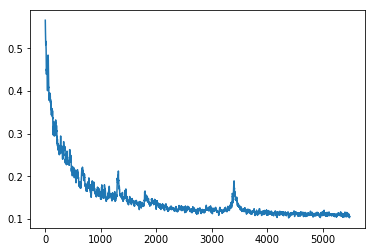

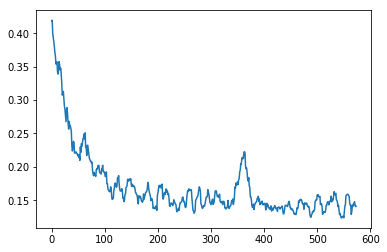

In [31]:

plt.plot(moving_average(np.flip(Ldc))); plt.show()
plt.plot(moving_average(np.flip(Lvdc))); plt.show()


In [32]:

my_dict={}
my_dict_val={}
valider(model,1)

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.21)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss

('Epoch: ', 1, ' Batch: ', 85, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 86, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 87, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 88, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 89, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 90, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 91, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 92, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 93, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE: ', 0.116, ' Loss :', 0.209)
('Epoch: ', 1, ' Batch: ', 94, ' Dice0: ', 0.041, ' Dice1: ', 0.146, ' CE

('Epoch: ', 1, ' Batch: ', 169, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 170, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 171, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 172, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 173, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 174, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 175, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 176, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 177, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.208)
('Epoch: ', 1, ' Batch: ', 178, ' Dice0: ', 0.041, ' Dice1: ', 0

('Epoch: ', 1, ' Batch: ', 253, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 254, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 255, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 256, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 257, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 258, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 259, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 260, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 261, ' Dice0: ', 0.041, ' Dice1: ', 0.145, ' CE: ', 0.115, ' Loss :', 0.207)
('Epoch: ', 1, ' Batch: ', 262, ' Dice0: ', 0.041, ' Dice1: ', 0

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('Val Dice0', 0.034, ' Dice1: ', 0.124, ' CE: ', 0.109, ' Loss :', 0.207078)
('Val Dice0', 0.047, ' Dice1: ', 0.127, ' CE: ', 0.212, ' Loss :', 0.207078)
('Val Dice0', 0.029, ' Dice1: ', 0.094, ' CE: ', 0.073, ' Loss :', 0.207078)
('Val Dice0', 0.03, ' Dice1: ', 0.38, ' CE: ', 0.156, ' Loss :', 0.207078)
('Val Dice0', 0.045, ' Dice1: ', 0.144, ' CE: ', 0.143, ' Loss :', 0.207078)
('Val Dice0', 0.044, ' Dice1: ', 0.135, ' CE: ', 0.129, ' Loss :', 0.207078)
('Val Dice0', 0.05, ' Dice1: ', 0.174, ' CE: ', 0.202, ' Loss :', 0.207078)
('Val Dice0', 0.02, ' Dice1: ', 0.151, ' CE: ', 0.062, ' Loss :', 0.207078)
('Val Dice0', 0.051, ' Dice1: ', 0.151, ' CE: ', 0.194, ' Loss :', 0.207078)
('Val Dice0', 0.031, ' Dice1: ', 0.095, ' CE: ', 0.084, ' Loss :', 0.207078)
('Val Dice0', 0.024, ' Dice1: ', 0.095, ' CE: ', 0.064, ' Loss :', 0.207078)
('Val Dice0', 0.06, ' Dice1: ', 0.161, ' CE: ', 0.269, ' Loss :', 0.207078)
('Val Dice0', 0.097, ' Dice1: ', 0.318, ' CE: ', 0.474, ' Loss :', 0.207078)
('Va

In [33]:
d1val=my_dict_val.copy()
d1t=my_dict.copy()

('Global Mean: ', 0.8497303258627653)
('Global Std: ', 0.0600679815363124)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.872942590713501)
('Number clipped: ', 7, 'of total ', 32)
Suspects: 
('horse207.jpg', [0.8319228887557983])
('horse296.jpg', [0.8183851838111877])
('horse224.jpg', [0.6821994781494141])
('horse266.jpg', [0.8262843489646912])
('horse091.jpg', [0.6198232173919678])
('horse295.jpg', [0.8385382890701294])
('horse089.jpg', [0.7506522536277771])
--
--
Min: 0.620
Q1: 0.847
Median: 0.861
Q3: 0.884
Max: 0.906


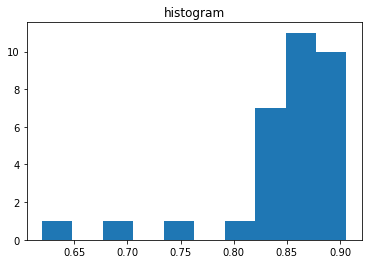

In [36]:
vals=val_stats(make_b(d1val),0.84)

('Global Mean: ', 0.8873749600874411)
('Global Std: ', 0.017567794855518397)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.888645249686829)
('Number clipped: ', 4, 'of total ', 296)
Suspects: 
('horse087.jpg', [0.8017910122871399])
('horse011.jpg', [0.7454107999801636])
('horse123.jpg', [0.8281419277191162])
('horse072.jpg', [0.8032315373420715])
--
--
Min: 0.745
Q1: 0.880
Median: 0.888
Q3: 0.898
Max: 0.931


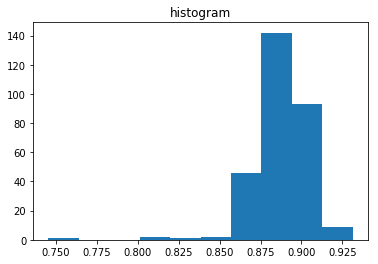

In [37]:
trans=val_stats(make_b(d1t),0.84)

In [76]:
#     Avg score of hard vals
c=[]
for e in vals:
    c.append(vals[e][0])
print(sum(c)/len(c))

#     Avg score of hard trains
c=[]
for e in trans:
    c.append(trans[e][0])
print(sum(c)/len(c))
    # higher val score indicates hard samples in val are using easier train features. Lets see if feats of hard help much for val

0.741853684187
0.701598853977


In [26]:
model.load_state_dict(torch.load('init_leaf'))
# # 

In [23]:
torch.save(model.state_dict(),'init_leaf')

In [196]:
# get list of hard examples
l1=[]
for e in vals:l1.append(e)
    
l2=[]
for e in trans:l2.append(e)

In [197]:
dataset2 = CustomDataset(l2)
dataset_val2=CustomDataset(l1)   

model2=UNet(1,2).cuda()
opt2 = torch.optim.Adam(model2.parameters(), lr=init_lr)# add weight decay cause less imgs

In [198]:
len(dataset2),len(dataset_val2)

(56, 12)

In [158]:

my_dict={}
my_dict_val={}

L=np.array([]);Lc=np.array([]);Ld=np.array([]);Lv=np.array([]);Lvd=np.array([]);Lvc=np.array([]);L_r=np.array([]);Ldc=np.array([]);Lvdc=np.array([])


In [199]:
data_loader2 = DataLoader(dataset2, batch_size//2, shuffle=True, num_workers=2) # decrease bs's for more updates
val_loader2=DataLoader(dataset_val2,batch_size_val//2,shuffle=True, num_workers=2) 
loaders2={'train':data_loader2,'val': val_loader2}

trainer(model2,80,loaders2,opt2)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.235, ' CE: ', 0.021, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.143)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.022, ' Loss :', 0.144)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.237, ' CE: ', 0.02

('Epoch: ', 6, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 6, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.238, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 6, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.023, ' Loss :', 0.146)
('Epoch: ', 6, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.239, ' CE: ', 0.02

('Epoch: ', 11, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 11, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.145)
('Epoch: ', 11, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' CE: ', 0.023, ' Loss :', 0.144)
('Epoch: ', 11, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.236, ' C

('Epoch: ', 16, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.233, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' CE: ', 0.023, ' Loss :', 0.142)
('Epoch: ', 16, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.232, ' C

('Epoch: ', 21, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.228, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' CE: ', 0.022, ' Loss :', 0.139)
('Epoch: ', 21, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.227, ' C

('Epoch: ', 26, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.223, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' CE: ', 0.022, ' Loss :', 0.136)
('Epoch: ', 26, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.222, ' C

('Epoch: ', 31, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.218, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.217, ' CE: ', 0.021, ' Loss :', 0.133)
('Epoch: ', 31, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.217, ' C

('Epoch: ', 36, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.213, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.021, ' Loss :', 0.13)
('Epoch: ', 36, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.212, ' CE: ', 0.0

('Epoch: ', 41, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.208, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.02, ' Loss :', 0.127)
('Epoch: ', 41, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.207, ' CE: ', 0.0

('Epoch: ', 46, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.203, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.02, ' Loss :', 0.124)
('Epoch: ', 46, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.202, ' CE: ', 0.0

('Epoch: ', 51, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' CE: ', 0.019, ' Loss :', 0.121)
('Epoch: ', 51, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.198, ' C

('Epoch: ', 56, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' CE: ', 0.019, ' Loss :', 0.119)
('Epoch: ', 56, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.194, ' C

('Epoch: ', 61, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.191, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.117)
('Epoch: ', 61, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0.019, ' Loss :', 0.116)
('Epoch: ', 61, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.19, ' CE: ', 0

('Epoch: ', 66, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.187, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' CE: ', 0.018, ' Loss :', 0.114)
('Epoch: ', 66, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.186, ' C

('Epoch: ', 71, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.183, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.112)
('Epoch: ', 71, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' CE: ', 0.018, ' Loss :', 0.111)
('Epoch: ', 71, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.182, ' C

('Epoch: ', 76, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.018, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.179, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' CE: ', 0.017, ' Loss :', 0.109)
('Epoch: ', 76, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.178, ' C

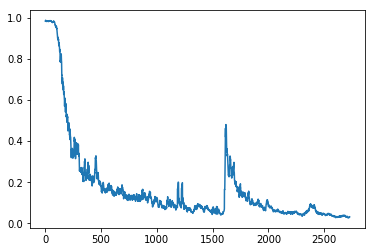

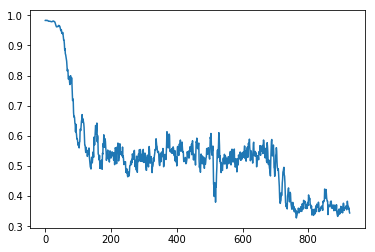

In [200]:

plt.plot(moving_average(np.flip(Ldc))); plt.show()
plt.plot(moving_average(np.flip(Lvdc))); plt.show()


In [201]:
my_dict={}
my_dict_val={}
data_loader2 = DataLoader(dataset2, 1, shuffle=True, num_workers=2) # decrease bs's for more updates
val_loader2=DataLoader(dataset_val2,1,shuffle=True, num_workers=2) 
loaders2={'train':data_loader2,'val': val_loader2}
valider(model2,loaders2)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.017, ' Loss :', 0.107)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.175, ' CE: ', 0.01

('Global Mean: ', 0.5977116127808889)
('Global Std: ', 0.22187541126079569)
('Epoch: ', -1, 'with ', 0, 'below')
('Number clipped: ', 12, 'of total ', 12)
Suspects: 
('P0211', [0.7604595422744751])
('P0212', [0.7096583247184753])
('P0098', [0.733039140701294])
('P0071', [0.6701338291168213])
('P0084', [0.34027302265167236])
('P0016', [5.185604095458984e-06])
('P0225', [0.6706128120422363])
('P0015', [0.46084582805633545])
('P0133', [0.7891159057617188])
('P0056', [0.6957606673240662])
('P0243', [0.7797324657440186])
('P0054', [0.5629026293754578])
--
--
Min: 0.000
Q1: 0.537
Median: 0.683
Q3: 0.740
Max: 0.789


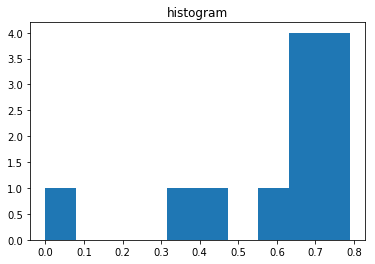

In [202]:
vals2=val_stats(make_b(my_dict_val))

('Global Mean: ', 0.9373319808925901)
('Global Std: ', 0.0767060666592866)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.9694421180972347)
('Number clipped: ', 29, 'of total ', 56)
Suspects: 
('P0086', [0.9458372592926025])
('P0166', [0.9563416242599487])
('P0242', [0.9462301731109619])
('P0073', [0.8836387991905212])
('P0001', [0.9343465566635132])
('P0041', [0.959651529788971])
('P0029', [0.9585357308387756])
('P0042', [0.7752232551574707])
('P0100', [0.9367650151252747])
('P0101', [0.9312624335289001])
('P0226', [0.4698340892791748])
('P0222', [0.9542945027351379])
('P0009', [0.9391080141067505])
('P0199', [0.8766907453536987])
('P0213', [0.9014856815338135])
('P0151', [0.9557918310165405])
('P0196', [0.946227490901947])
('P0179', [0.9476196765899658])
('P0136', [0.8976871967315674])
('P0117', [0.9375079274177551])
('P0013', [0.9465553164482117])
('P0011', [0.9326315522193909])
('P0050', [0.9387297034263611])
('P0118', [0.9439133405685425])
('P0031', [0.9538902044296265]

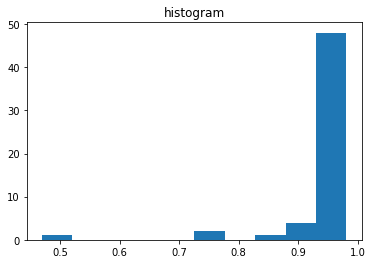

In [203]:
trans2=val_stats(make_b(my_dict),0.96)

In [193]:
diff_checker2(vals2,vals)
# vals,vals2

('P0071', ' : ', -0.6143157482147217)
('P0212', ' : ', -0.07553654909133911)
('P0098', ' : ', -0.17135274410247803)
('P0211', ' : ', -0.7704473733901978)
('P0084', ' : ', -0.2670705318450928)
('P0016', ' : ', -0.6101529002189636)
('P0015', ' : ', 0.24667054414749146)
('P0133', ' : ', -0.6879265308380127)
('P0056', ' : ', 0.02297908067703247)
('P0225', ' : ', 0.2719414234161377)
('P0243', ' : ', -0.02672046422958374)
('P0054', ' : ', 0.09298735857009888)


{'P0015': [0.526771605014801, 0.28010106086730957, 0.24667054414749146],
 'P0016': [0.03930926322937012, 0.6494621634483337, -0.6101529002189636],
 'P0054': [0.8017757534980774, 0.7087883949279785, 0.09298735857009888],
 'P0056': [0.7773027420043945, 0.7543236613273621, 0.02297908067703247],
 'P0071': [0.11850279569625854, 0.7328185439109802, -0.6143157482147217],
 'P0084': [0.47959959506988525, 0.746670126914978, -0.2670705318450928],
 'P0098': [0.6201017498970032, 0.7914544939994812, -0.17135274410247803],
 'P0133': [0.03305536508560181, 0.7209818959236145, -0.6879265308380127],
 'P0211': [0.00033080577850341797, 0.7707781791687012, -0.7704473733901978],
 'P0212': [0.6125690340995789, 0.688105583190918, -0.07553654909133911],
 'P0225': [0.5979064106941223, 0.3259649872779846, 0.2719414234161377],
 'P0243': [0.7632434368133545, 0.7899639010429382, -0.02672046422958374]}

In [204]:
diff_checker2(vals2,vals)


('P0211', ' : ', -0.010318636894226074)
('P0212', ' : ', 0.021552741527557373)
('P0098', ' : ', -0.058415353298187256)
('P0071', ' : ', -0.06268471479415894)
('P0084', ' : ', -0.40639710426330566)
('P0016', ' : ', -0.6494569778442383)
('P0015', ' : ', 0.18074476718902588)
('P0133', ' : ', 0.06813400983810425)
('P0056', ' : ', -0.0585629940032959)
('P0225', ' : ', 0.3446478247642517)
('P0243', ' : ', -0.010231435298919678)
('P0054', ' : ', -0.14588576555252075)


{'P0015': [0.46084582805633545, 0.28010106086730957, 0.18074476718902588],
 'P0016': [5.185604095458984e-06, 0.6494621634483337, -0.6494569778442383],
 'P0054': [0.5629026293754578, 0.7087883949279785, -0.14588576555252075],
 'P0056': [0.6957606673240662, 0.7543236613273621, -0.0585629940032959],
 'P0071': [0.6701338291168213, 0.7328185439109802, -0.06268471479415894],
 'P0084': [0.34027302265167236, 0.746670126914978, -0.40639710426330566],
 'P0098': [0.733039140701294, 0.7914544939994812, -0.058415353298187256],
 'P0133': [0.7891159057617188, 0.7209818959236145, 0.06813400983810425],
 'P0211': [0.7604595422744751, 0.7707781791687012, -0.010318636894226074],
 'P0212': [0.7096583247184753, 0.688105583190918, 0.021552741527557373],
 'P0225': [0.6706128120422363, 0.3259649872779846, 0.3446478247642517],
 'P0243': [0.7797324657440186, 0.7899639010429382, -0.010231435298919678]}

/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rahul/vEnv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


('horse224.jpg', tensor(0.6822, device='cuda:0'))


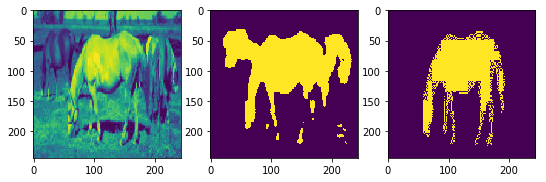

('horse089.jpg', tensor(0.7507, device='cuda:0'))


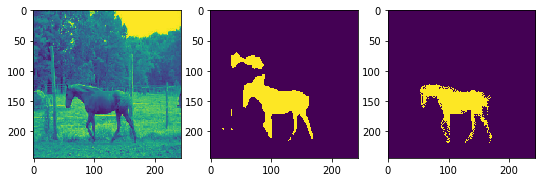

('horse024.jpg', tensor(0.8485, device='cuda:0'))


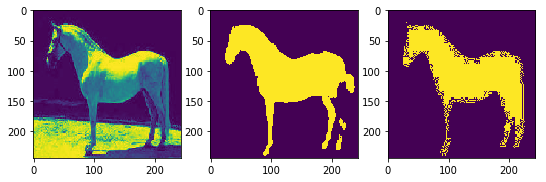

('horse073.jpg', tensor(0.8730, device='cuda:0'))


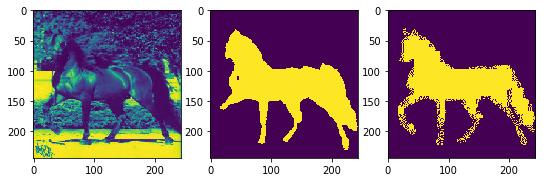

('horse265.jpg', tensor(0.8780, device='cuda:0'))


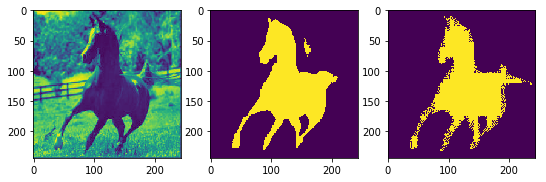

('horse183.jpg', tensor(0.8553, device='cuda:0'))


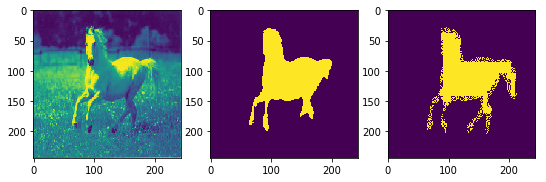

('horse296.jpg', tensor(0.8184, device='cuda:0'))


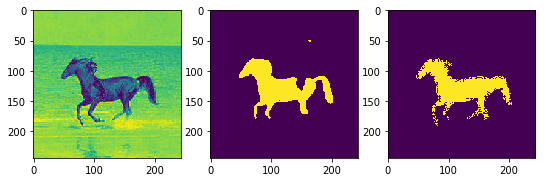

('horse143.jpg', tensor(0.9052, device='cuda:0'))


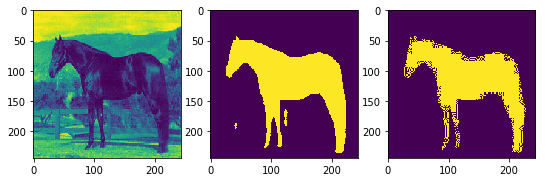

('horse227.jpg', tensor(0.8562, device='cuda:0'))


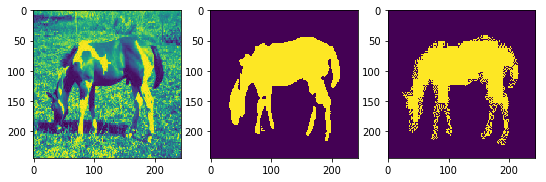

('horse266.jpg', tensor(0.8263, device='cuda:0'))


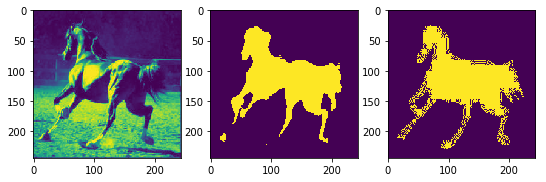

('horse160.jpg', tensor(0.8590, device='cuda:0'))


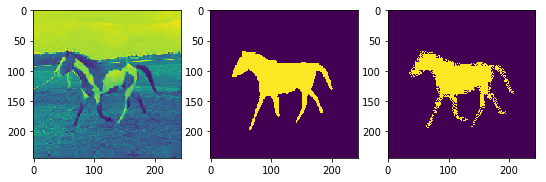

('horse295.jpg', tensor(0.8385, device='cuda:0'))


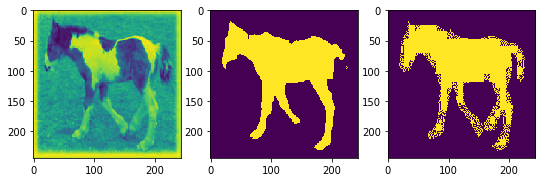

('horse018.jpg', tensor(0.8894, device='cuda:0'))


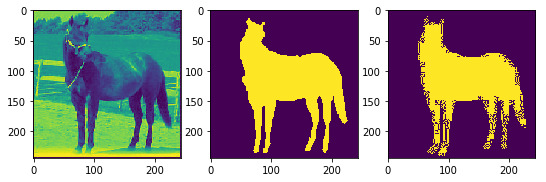

('horse122.jpg', tensor(0.8650, device='cuda:0'))


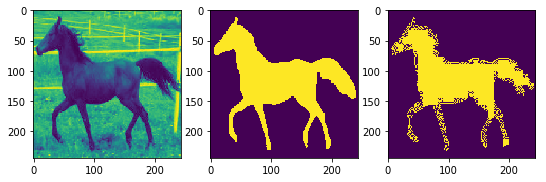

('horse208.jpg', tensor(0.8764, device='cuda:0'))


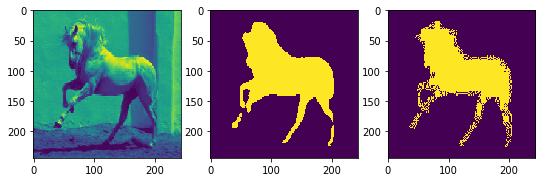

('horse207.jpg', tensor(0.8319, device='cuda:0'))


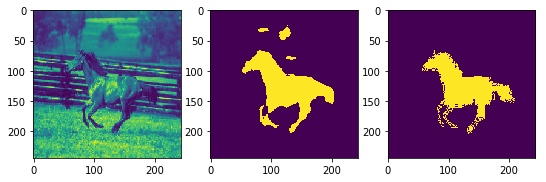

('horse217.jpg', tensor(0.8627, device='cuda:0'))


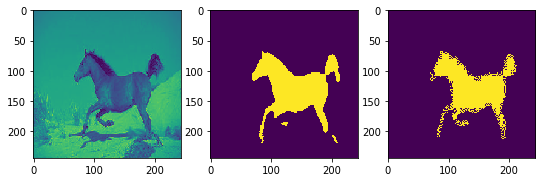

('horse314.jpg', tensor(0.8903, device='cuda:0'))


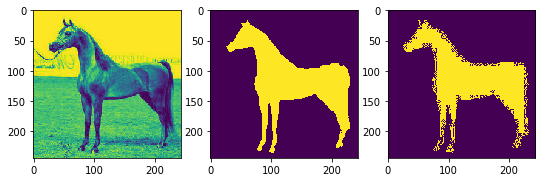

('horse165.jpg', tensor(0.8741, device='cuda:0'))


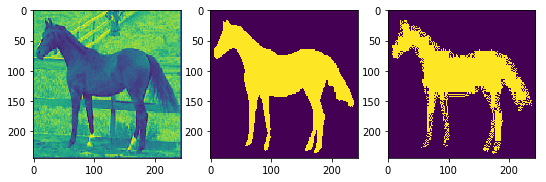

('horse028.jpg', tensor(0.8917, device='cuda:0'))


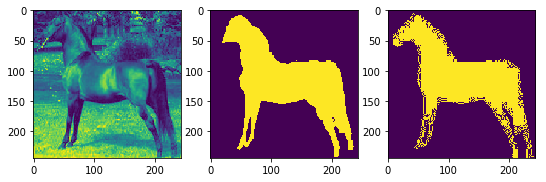

('horse239.jpg', tensor(0.8472, device='cuda:0'))


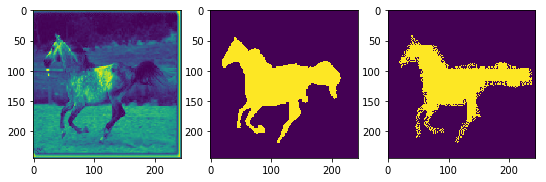

('horse139.jpg', tensor(0.8458, device='cuda:0'))


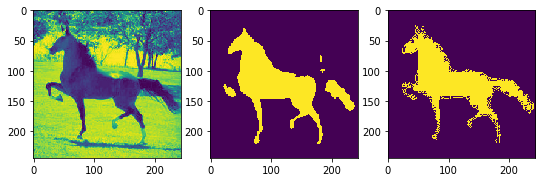

('horse201.jpg', tensor(0.9054, device='cuda:0'))


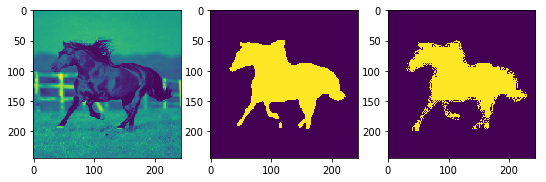

('horse290.jpg', tensor(0.8828, device='cuda:0'))


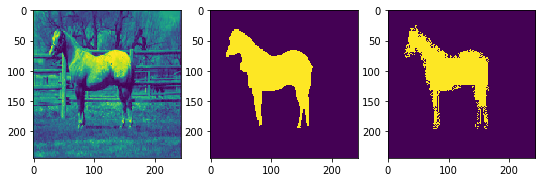

('horse283.jpg', tensor(0.8890, device='cuda:0'))


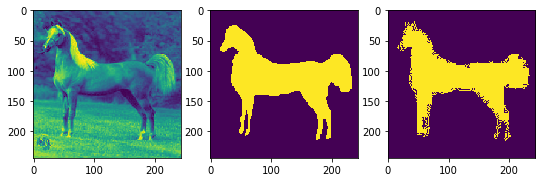

('horse130.jpg', tensor(0.8538, device='cuda:0'))


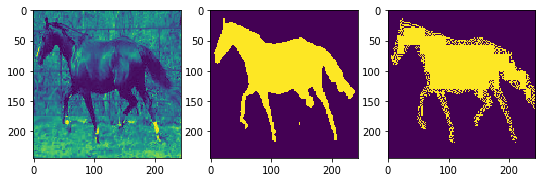

('horse091.jpg', tensor(0.6198, device='cuda:0'))


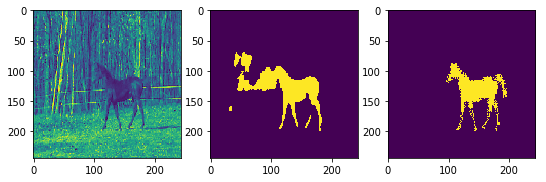

('horse322.jpg', tensor(0.8648, device='cuda:0'))


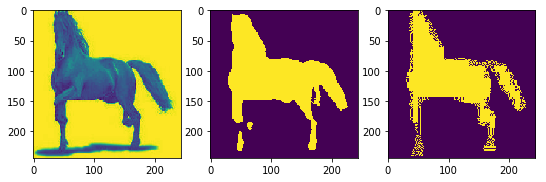

('horse172.jpg', tensor(0.8485, device='cuda:0'))


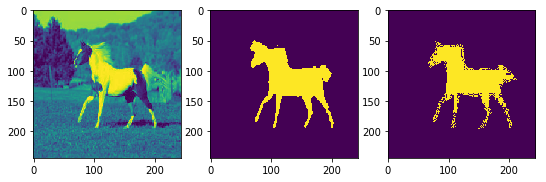

('horse004.jpg', tensor(0.9060, device='cuda:0'))


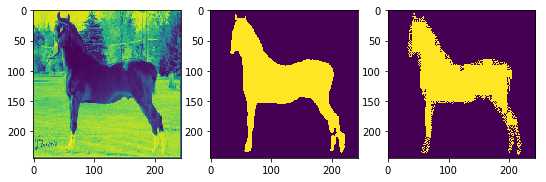

('horse013.jpg', tensor(0.8970, device='cuda:0'))


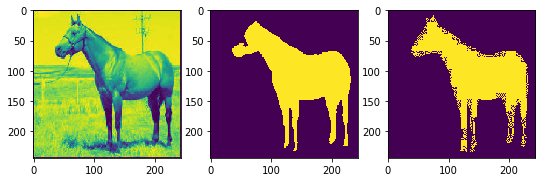

('horse126.jpg', tensor(0.8584, device='cuda:0'))


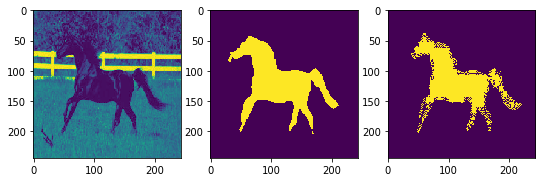

In [38]:
val_vis=DataLoader(NDataset('val') ,1,shuffle=True, num_workers=2) 


with torch.set_grad_enabled(False):    
    for idx, batch_data in enumerate(val_vis):
        h=np.random.randint(0,1000-193)
        w=np.random.randint(0,1000-193)
        name=batch_data['name']
        input = Variable(batch_data['image']).float().cuda()
        dice_mask = Variable(batch_data['mask']).float().cuda()
        ce_tar=Variable(batch_data['mask2']).cuda()
                    

        pred_mask = model(input)

        ce = loss_fn(pred_mask, ce_tar.long())
        soft_mask=soft_max(pred_mask)
    #                 dice=dice_loss_classes(soft_mask, batch_gt_mask)

        a,b=dice_loss_classes(soft_mask, dice_mask)
        plt.figure(figsize=(9,9))
        plt.subplot(1,3,1)
        plt.imshow(input[0].transpose(0,1).transpose(2,1).cpu().detach()[:,:,0] )

        arg=torch.argmax(soft_mask,1)
        plt.subplot(1,3,2)
        plt.imshow(arg[0].cpu().detach())
        plt.subplot(1,3,3)
        print(name[0],1-b)
        plt.imshow(ce_tar[0].cpu().detach())
        plt.show()

#                 print('Dice Losses: ',a.item(),b.item())
                
                